In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
from module8_healthia import health_impact

In [2]:
# Define paths for shapefiles
path_fichier_shp = "data/2-output-data/donnees_shp"
path_fichier_shp_1 = "data/2-output-data/donnees_shp_1"
path_fichier_shp_2 = "data/2-output-data/donnees_shp_2"
path_fichier_shp_3 = "data/2-output-data/donnees_shp_3"
path_fichier_pourcents = "data/2-output-data"

# Titles for INSEE Data
title_shp = "donnees_insee_iris"
title_shp_1 = "donnees_insee_iris_toutage_1"
title_shp_2 = "donnees_insee_iris_toutage_2"
title_shp_3 = "donnees_insee_iris_toutage_3"
title_pourcents = "pourcents"

# Read shapefiles into GeoDataFrames
donnees_shp = gpd.read_file(os.path.join(path_fichier_shp, f"{title_shp}.shp"))
donnees_shp_1 = gpd.read_file(os.path.join(path_fichier_shp_1, f"{title_shp_1}.shp"))
donnees_shp_2 = gpd.read_file(os.path.join(path_fichier_shp_2, f"{title_shp_2}.shp"))
donnees_shp_3 = gpd.read_file(os.path.join(path_fichier_shp_3, f"{title_shp_3}.shp"))

# Combine the three GeoDataFrames
donnees_merged = gpd.GeoDataFrame(pd.concat([donnees_shp_1, donnees_shp_2, donnees_shp_3], ignore_index=True))


In [15]:
# Load exposure shapefile
base_path = r"data\2-output-data"
scenario = "s1"
pollutant = "ug_PM25_rh50"
year = "2030"

# Path to the shapefile
shapefile_path = os.path.join(base_path, scenario, pollutant, year, "donnees_expo.shp")
assert os.path.exists(shapefile_path), f"Shapefile not found at {shapefile_path}"
health_gdf = gpd.read_file(shapefile_path)

# Check if 'meanconc' column exists in health_gdf
if "meanconc" not in health_gdf.columns:
    raise KeyError("'meanconc' column is missing in the shapefile loaded into health_gdf. Ensure the input shapefile contains this column.")

# Filter based on the age criteria (30 < age < 99)
merged_gdf = donnees_merged[(donnees_merged['age'] > 30) & (donnees_merged['age'] < 99)]

# Merge health_gdf with merged_gdf on 'iriscod'
merged_gdf = merged_gdf.merge(health_gdf, on="iriscod", how="inner", suffixes=("_x", "_y"))

# Check whether all 'iriscod' in aggregated_gdf are present in health_gdf
missing_iriscod = aggregated_gdf.loc[~aggregated_gdf['iriscod'].isin(health_gdf['iriscod']), 'iriscod']
if not missing_iriscod.empty:
    raise KeyError(f"The following 'iriscod' values are present in aggregated_gdf but missing in health_gdf: {missing_iriscod.tolist()}")

# Check which columns are available after the merge
print("Columns in merged_gdf:", merged_gdf.columns)

# Dynamically select columns for population (pop) and mortality (mort) based on the year
pop_column = f"pop{year}_x" if f"pop{year}_x" in merged_gdf.columns else f"pop{year}_y"
mort_column = f"mort{year}_x" if f"mort{year}_x" in merged_gdf.columns else f"mort{year}_y"
geometry_column = "geometry_x" if "geometry_x" in merged_gdf.columns else "geometry_y"

# Group by iriscod and aggregate data
# Sum up the population and mortality, and take the first geometry for each iriscod
# Retain non-aggregated columns 'meanconc' and 'meandelta' using 'first'
aggregated_gdf = (
    merged_gdf
    .groupby("iriscod", as_index=False)
    .agg(
        **{f"pop{year}": (pop_column, "sum")},
        **{f"mort{year}": (mort_column, "sum")},
        geometry=(geometry_column, "first"),  # Deduplicate geometry by taking the first one
        meanconc=("meanconc", "first"),       # Retain first value of 'meanconc'
        meandelta=("meandelta", "first")      # Retain first value of 'meandelta'
    )
)

# Inspect the resulting DataFrame
print("Aggregated DataFrame:")
print(aggregated_gdf.head())

Columns in merged_gdf: Index(['iriscod', 'irisname_x', 'comcod_x', 'comname_x', 'depcod_x',
       'depname_x', 'regcod_x', 'regname_x', 'age', 'pop2019_x', 'pop2030_x',
       'pop2050_x', 'mort2019_x', 'mort2030_x', 'mort2050_x', 'geometry_x',
       'pop2019_y', 'pop2030_y', 'pop2050_y', 'mort2019_y', 'mort2030_y',
       'mort2050_y', 'irisname_y', 'comcod_y', 'comname_y', 'depcod_y',
       'depname_y', 'regcod_y', 'regname_y', 'meanconc', 'meandelta',
       'geometry_y'],
      dtype='object')
Aggregated DataFrame:
     iriscod      pop2030   mort2030  \
0  010010000   548.181317   7.075953   
1  010020000   180.146877   2.325345   
2  010040101  1313.805545  16.958671   
3  010040102  2531.908061  32.682003   
4  010040201  2909.090585  37.550695   

                                            geometry  meanconc  meandelta  
0  POLYGON ((848555.1 6560252.4, 848538.7 6560263...  5.999943   2.677045  
1  POLYGON ((886326.9 6547939, 886100.5 6548125.4...  5.933606   2.067206  
2  

In [22]:
# Load exposure shapefile
base_path = r"data\2-output-data"
scenario = "s1"
pollutant = "ug_PM25_rh50"
year = "2030"

# Verify that 'meanconc' exists in 'aggregated_gdf'
if "meanconc" not in aggregated_gdf.columns:
    raise KeyError("'meanconc' column is missing in the aggregated_gdf. Ensure it is part of the DataFrame.")

# Calculate health impact metrics
aggregated_gdf['ar_lyl'] = 11  # Average years of life lost per death
aggregated_gdf['ar_drate'] = aggregated_gdf[f'mort{year}'] / aggregated_gdf[f'pop{year}']  # Death rate

# Retain all rows, even if they contain missing values, for further inspection
# Rows with missing values in critical columns will not be dropped
# aggregated_gdf = aggregated_gdf.dropna(subset=[f"pop{year}", f"mort{year}", "ar_drate", "ar_lyl", "meanconc", "geometry"])

# Display filtered data and calculations for inspection
print("First few rows of aggregated_gdf (with potential missing values):")
print(aggregated_gdf[['iriscod', 'ar_drate', f'pop{year}', "geometry"]].head())

# Convert necessary columns to numpy arrays
pop30plus = aggregated_gdf[f"pop{year}"].to_numpy()
pm25_conc = aggregated_gdf["meanconc"].to_numpy()
ar_drate = aggregated_gdf["ar_drate"].to_numpy()
ar_lyl = aggregated_gdf["ar_lyl"].to_numpy()

# Display the first few values of each numpy array for inspection
print("\nConverted numpy arrays:")
print(f"pop30plus (first 5): {pop30plus[:5]}")
print(f"pm25_conc (first 5): {pm25_conc[:5]}")
print(f"ar_drate (first 5): {ar_drate[:5]}")
print(f"ar_lyl (first 5): {ar_lyl[:5]}")

# Call health impact function
approx_method = 'e'  # specify method ('e' or 'l')
mort, dll, dll_spec = health_impact(pop30plus, pm25_conc, ar_drate, ar_lyl, approx=approx_method)

# Add results back to GeoDataFrame
aggregated_gdf["mort_low"] = mort[0]
aggregated_gdf["mort_mid"] = mort[1]
aggregated_gdf["mort_high"] = mort[2]

aggregated_gdf["dll_low"] = dll[0]
aggregated_gdf["dll_mid"] = dll[1]
aggregated_gdf["dll_high"] = dll[2]

aggregated_gdf["dllsp_low"] = dll_spec[0]  # Shortened column name
aggregated_gdf["dllsp_mid"] = dll_spec[1]  # Shortened column name
aggregated_gdf["dllsp_high"] = dll_spec[2]  # Shortened column name

# Ensure the GeoDataFrame remains valid for further processing or saving
aggregated_gdf = gpd.GeoDataFrame(aggregated_gdf, geometry='geometry')

First few rows of aggregated_gdf (with potential missing values):
     iriscod  ar_drate      pop2030  \
0  010010000  0.012908   548.181317   
1  010020000  0.012908   180.146877   
2  010040101  0.012908  1313.805545   
3  010040102  0.012908  2531.908061   
4  010040201  0.012908  2909.090585   

                                            geometry  
0  POLYGON ((848555.1 6560252.4, 848538.7 6560263...  
1  POLYGON ((886326.9 6547939, 886100.5 6548125.4...  
2  POLYGON ((880354.4 6543354, 880385.3 6543654.8...  
3  POLYGON ((882936.4 6541364.3, 882932.9 6541311...  
4  POLYGON ((882245.2 6542954.3, 882137.9 6543223...  

Converted numpy arrays:
pop30plus (first 5): [ 548.18131733  180.14687707 1313.80554486 2531.90806128 2909.09058514]
pm25_conc (first 5): [5.99994261 5.93360568 5.9971962  6.01088274 5.9971962 ]
ar_drate (first 5): [0.01290805 0.01290805 0.01290805 0.01290805 0.01290805]
ar_lyl (first 5): [11 11 11 11 11]


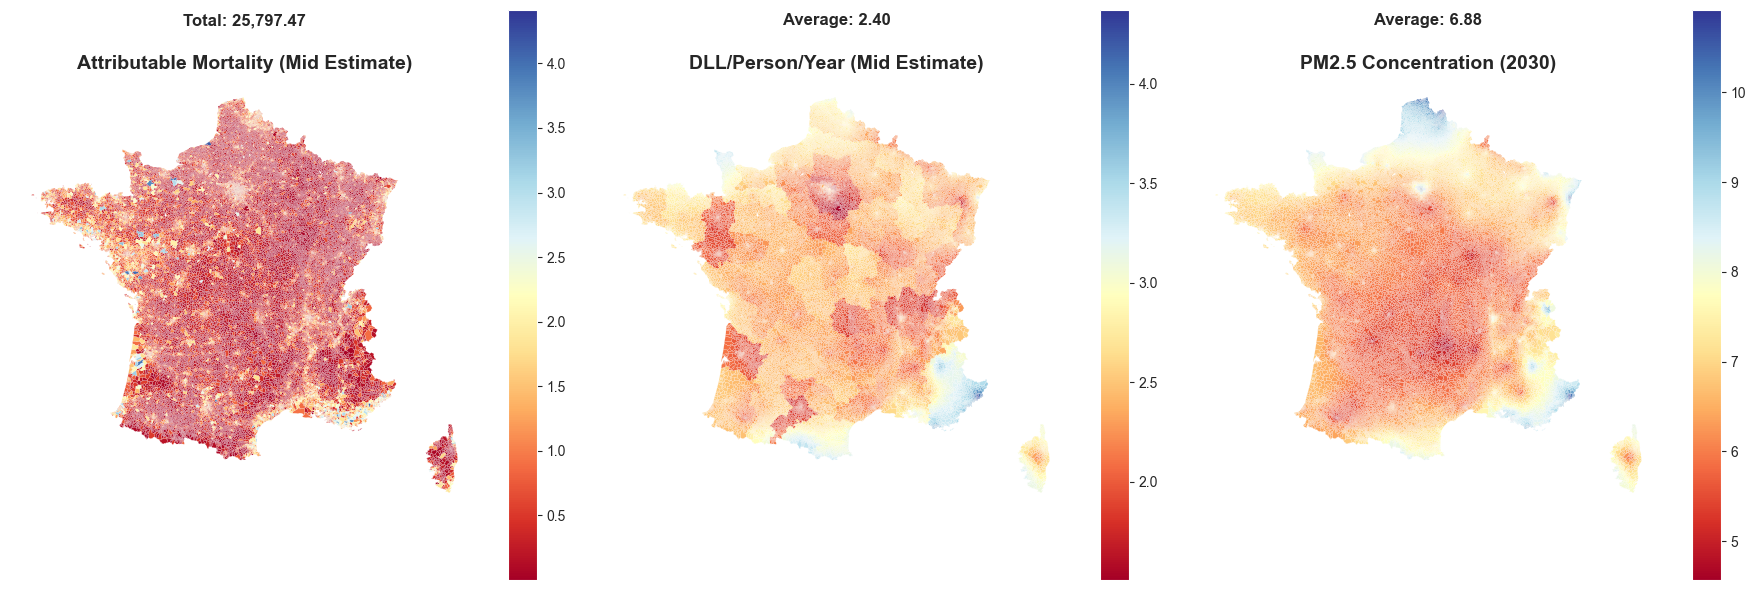

In [23]:
def plot_multiple_iris_maps(
    iris_level_results, iris_shapefile, columns_to_plot, titles=None, cmap="RdYlBu", base_path="data/2-output-data"
):
    # Merge shapefile geometry with results
    plot_data = iris_shapefile.merge(iris_level_results, on="iriscod", how="left")
    if "geometry" not in plot_data.columns or not isinstance(plot_data.geometry, gpd.GeoSeries):
        # Ensure geometry assignment has a fallback
        geometry_column = "geometry_x" if "geometry_x" in plot_data else iris_shapefile.geometry
        plot_data = gpd.GeoDataFrame(plot_data, geometry=geometry_column, crs=iris_shapefile.crs)

    # Ensure titles align with number of columns to plot
    n_maps = len(columns_to_plot)
    if titles is None:
        titles = columns_to_plot
    elif len(titles) != n_maps:
        raise ValueError("The length of titles must match the length of columns_to_plot.")

    # Handle single or multiple subplots
    if n_maps == 1:
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes = [axes]  # Wrap single axis in a list for consistency
    else:
        fig, axes = plt.subplots(1, n_maps, figsize=(18, 6))

    # Iterate over columns and plot
    for i, column in enumerate(columns_to_plot):
        ax = axes[i] if n_maps > 1 else axes[0]  # Handle single or multiple plots cleanly
        if pd.api.types.is_numeric_dtype(plot_data[column]):
            # Plot GeoDataFrame
            plot_data.plot(
                column=column,
                cmap=cmap,
                linewidth=0.1,
                edgecolor="white",
                legend=True,
                ax=ax,
                vmin=plot_data[column].min(),
                vmax=plot_data[column].max(),
            )
            # Calculate annotation value
            if column == "mort_mid":
                annotation_value = plot_data[column].sum()  # Total for mortality
                annotation_label = "Total"
            else:
                annotation_value = plot_data[column].mean()  # Otherwise use mean
                annotation_label = "Average"

            # Annotate the plot
            ax.set_title(titles[i], fontsize=14, fontweight="bold")
            ax.text(
                0.5, 1.12,
                f"{annotation_label}: {annotation_value:,.2f}",
                transform=ax.transAxes,
                ha="center", fontsize=12, fontweight="bold"
            )
            ax.axis("off")
        else:
            # Handle non-numeric data columns
            ax.set_title(f"{titles[i]} (Non-numeric data)", fontsize=14, fontweight="bold")
            ax.axis("off")

    plt.tight_layout()

    # Save and show plot
    output_filename = f"iris_mortality_maps_{approx_method}.png"  # Save dynamically based on `approx_method`
    output_path = os.path.join(base_path, output_filename)
    plt.savefig(output_path, dpi=300)
    plt.show()

# Call the function with appropriate inputs
plot_multiple_iris_maps(
    iris_level_results=aggregated_gdf,
    iris_shapefile=donnees_shp,
    columns_to_plot=["mort_mid", "dllsp_mid", "meanconc"],
    titles=["Attributable Mortality (Mid Estimate)", "DLL/Person/Year (Mid Estimate)", "PM2.5 Concentration (2030)"],
    cmap="RdYlBu"
)